In [3]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

def load_python_data(file_path):
    python_data = loadmat(file_path)
    params = python_data['sim_parameters']
    Efield = python_data['Efield']
    distrib_fcts = python_data['distrib_fct']
    
    return params, Efield, distrib_fcts


path = r'C:\Users\Clément\Documents\M2 Physique Fondamentale & Applications - Univers & Particules\Internship\GitHub_Repo\PlasmaSim\LDCV'

N_ref = 2**9
dt_ref = 2**(-8)

N_list = [2**5, 2**6, 2**7, 2**8]
dt_list = [2**(-7), 2**(-6), 2**(-5), 2**(-4), 2**(-3)]


_, _, distrib_fcts_ref = load_python_data(f'{path}\LDCV_N_{N_ref}_dt_{dt_ref}.mat')
distrib_fcts_ref = distrib_fcts_ref[-1, :, :, :].squeeze()


temporal_convergence_data = []
    
for dt in dt_list:
    _, _, distrib_fcts = load_python_data(f'{path}\LDCV_N_{N_ref}_dt_{dt}.mat')
    distrib_fcts = distrib_fcts[-1, :, :, :].squeeze().reshape(distrib_fcts.shape[3]**2)
    print(distrib_fcts.shape)
    
    temporal_convergence_data.append(distrib_fcts)
    
    
spatial_convergence_data = []

for N in N_list:
    _, _, distrib_fcts = load_python_data(f'{path}\LDCV_N_{N}_dt_{dt_ref}.mat')
    distrib_fcts = distrib_fcts[-1, :, :, :].squeeze()
    print(distrib_fcts.shape)
    
    spatial_convergence_data.append(distrib_fcts)

(32, 32)
(64, 64)
(128, 128)
(256, 256)


In [8]:
from scipy.optimize import curve_fit
from scipy.stats import linregress

def power_law(x, a, b):
    return a * jnp.power(x, b)


def CVplot(x, y, kind):
    
    S = 12
    plt.rcParams['font.size'] = S
    plt.rcParams['axes.labelsize'] = S
    plt.rcParams['xtick.labelsize'] = S
    plt.rcParams['ytick.labelsize'] = S
    
    slope, intercept, r_value, p_value, std_err  = linregress(jnp.log(jnp.array(x)), jnp.log(jnp.array(y)))
    a = jnp.exp(intercept)
    b = slope
    print(f"Fitted parameters: a = {a:.4f}, b = {b:.4f}")
    x_fit = jnp.linspace(min(x), max(x), 100)
    y_fit = a * x_fit**b
    
    fig, ax = plt.subplots()
    ax.plot(x, y, 'o--')
    ax.plot(x_fit, y_fit, 'r', label=f'$y = {a:.4f}*x^{{{b:.4f}}}$')
    
    if kind == 'Temporal': 
        ax.set_xlabel(r'$\Delta t$')    
        labels = ['1/128', '1/64', '1/32', '1/16', '1/8']
    elif kind == 'Spatial': 
        ax.set_xlabel(r'$1/N$')
        labels = ['1/32', '1/64', '1/128', '1/256']

#N_list = [2**5, 2**6, 2**7, 2**8]
#dt_list = [2**(-7), 2**(-6), 2**(-5), 2**(-4), 2**(-3)]
    
    ax.set_xscale('log', base=2)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.set_yscale('log')
    ax.set_ylabel(r'$L^\infty-norm$')

    #ax.set_title(f'{kind} Convergence')
    ax.grid(True, which='both', ls=':')
    ax.legend()

    fig.tight_layout()
    fig.show()

In [ ]:
temporal_convergence = []

temp_ref = distrib_fcts_ref.reshape(distrib_fcts_ref.shape[0]*distrib_fcts_ref.shape[1])
print(temp_ref.shape)

for i in temporal_convergence_data:
    i.reshape(distrib_fcts_ref.shape[0]*distrib_fcts_ref.shape[1])
    print(i.shape)
    
    temp = jnp.linalg.norm(temp_ref - i, ord = jnp.inf)
    temporal_convergence.append(temp)
    
    
print(len(temporal_convergence))

(262144,)
(262144,)
(262144,)
(262144,)
(262144,)
(262144,)
5


In [5]:
spatial_convergence = []
power = [4,3,2,1]

for i in power:
    slicing = 2**i
    ref = distrib_fcts_ref[::slicing,::slicing]
    spa_ref = ref.reshape(ref.shape[0]*ref.shape[1])
    print(spa_ref.shape)
    spa_temp = spatial_convergence_data[-i].reshape(ref.shape[0]*ref.shape[1])
    print(spa_temp.shape)
    
    temp = jnp.linalg.norm(spa_ref - spa_temp, ord = jnp.inf)
    spatial_convergence.append(temp)
    
print(len(spatial_convergence))

(1024,)
(1024,)
(4096,)
(4096,)
(16384,)
(16384,)
(65536,)
(65536,)
4


Fitted parameters: a = 9.5729, b = 1.2920


C:\Users\Clément\AppData\Local\Temp\ipykernel_7808\3260253480.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


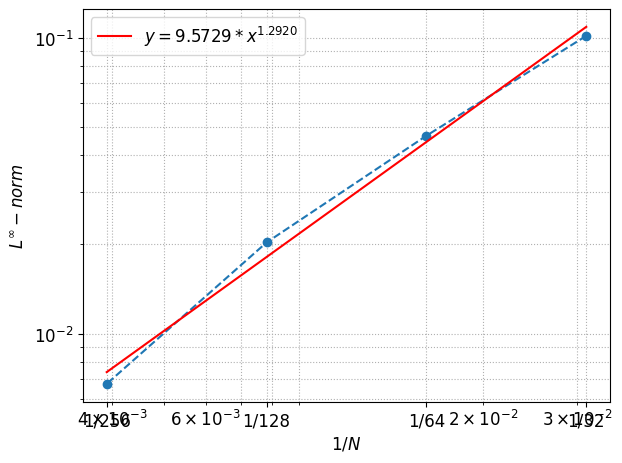

In [9]:
#CVplot(dt_list, temporal_convergence, kind='Temporal')
CVplot(1/jnp.array(N_list), spatial_convergence, kind='Spatial')

In [ ]:
from prettytable import PrettyTable

def EOC(norm_2N, norm_N):
    return jnp.log(norm_2N / norm_N) / jnp.log(2)


temporal_eoc = []
temporal_axis = []

for i in range(len(temporal_convergence)-1):
    temporal_eoc.append(EOC(temporal_convergence[i+1], temporal_convergence[i]))
    temporal_axis.append(dt_list[i+1])
    
temporal_table = PrettyTable(header=False)
temporal_table.add_row(["$\Delta t$", temporal_axis[0], temporal_axis[1], temporal_axis[2], temporal_axis[3]])
temporal_table.add_row(["$\Delta f$", temporal_eoc[0], temporal_eoc[1], temporal_eoc[2], temporal_eoc[3]])

print(temporal_table)


spatial_eoc = []
spatial_axis = []

for i in range(len(spatial_convergence)-1):
    spatial_eoc.append(EOC(spatial_convergence[i], spatial_convergence[i+1]))
    spatial_axis.append(N_list[i])
    
print(len(spatial_axis),len(spatial_eoc))
    
spatial_table = PrettyTable(header=False)
spatial_table.add_row(["$N$", spatial_axis[0], spatial_axis[1], spatial_axis[2]])
spatial_table.add_row(["$\Delta f$", spatial_eoc[0], spatial_eoc[1], spatial_eoc[2]])

print(spatial_table)


+------------+--------------------+--------------------+--------------------+--------------------+
| $\Delta t$ |      0.015625      |      0.03125       |       0.0625       |       0.125        |
| $\Delta f$ | 1.3945041467300199 | 1.1422370242036808 | 1.0311255978387919 | 0.9796470374902457 |
+------------+--------------------+--------------------+--------------------+--------------------+
3 3
+------------+--------------------+--------------------+--------------------+
|    $N$     |         32         |         64         |        128         |
| $\Delta f$ | 0.9757567209111869 | 1.1946067863475844 | 1.5780879171491577 |
+------------+--------------------+--------------------+--------------------+


In [ ]:
print(temporal_table.get_latex_string())
print(spatial_table.get_latex_string())

\begin{tabular}{ccccc}
$\Delta t$ & 0.015625 & 0.03125 & 0.0625 & 0.125 \\
$\Delta f$ & 1.3945041467300199 & 1.1422370242036808 & 1.0311255978387919 & 0.9796470374902457 \\
\end{tabular}
\begin{tabular}{cccc}
$N$ & 32 & 64 & 128 \\
$\Delta f$ & 0.9757567209111869 & 1.1946067863475844 & 1.5780879171491577 \\
\end{tabular}
